## PyTorch Introduction

Aufgabe:

* Trainieren Sie ein mehrschichtiges Neuronales Netz mit PyTorch.
* Zeigen Sie grafisch auf, dass Ihr Modell konvergiert.


#### Import & Settings

In [1]:
# in this code block we gather all imports

# PyTorch
import torch
import torch.nn as nn

# Data Splitting and Normalization is still often done using sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# numpy is just used in the beginning
import numpy as np

# for some plots and the scatter matrix
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm

# pandas for reading the CSV and for use with the library ppscore
import pandas as pd
from pandas.api.types import CategoricalDtype

# ppscore for exploratory data analysis
import ppscore as pps

# more statistics for exploratory data analysis
from scipy import stats


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('This Computation is running on {}.'.format(device))

This Computation is running on cpu.


#### Load Dataset

In [3]:
# in this code block we read the CSV file and perform some basic preprocessing

# read the CSV file
# using separator character semicolon
dataset_known_pd = pd.read_csv("../../data/iris_binary.csv", sep=',', skipinitialspace=True)

# make column names pythonic
# so that they can be used in code where applicable
dataset_known_pd.columns = dataset_known_pd.columns.str.replace(" ", "_")

# on a side note we choose to sort the data frame by the first column 
dataset_known_pd.sort_values(by='sepal_length', ascending=True, axis=0, inplace=True)

dataset_known_np = dataset_known_pd.to_numpy()

# number of target variables
n_targets = 1
print(f"n_targets={n_targets}")

# number of target classes
n_target_classes = 2
print(f"n_target_classes={n_target_classes}")

# number of instances
n_samples = dataset_known_np.shape[0]
print(f"n_samples={n_samples}")

# number of features
n_features = dataset_known_np.shape[1] - n_targets
print(f"n_features={n_features}")

assert dataset_known_pd.shape == (n_samples, n_features + n_targets)
assert dataset_known_np.shape == (n_samples, n_features + n_targets)

X_pd = dataset_known_pd.copy().drop('class', axis=1)
X_np = X_pd.to_numpy()
assert X_np.shape == (n_samples,n_features)

y_pd = dataset_known_pd['class'].copy()
y_np = y_pd.to_numpy()
assert y_np.shape == (n_samples,)

X = torch.from_numpy(X_np)
y = torch.from_numpy(y_np)


n_targets=1
n_target_classes=2
n_samples=150
n_features=4


In [4]:
dataset_known_pd

,sepal_length,sepal_width,petal_length,petal_width,class
22,4.3,3.0,1.1,0.1,0
128,4.4,2.9,1.4,0.2,0
141,4.4,3.0,1.3,0.2,0
3,4.4,3.2,1.3,0.2,0
47,4.5,2.3,1.3,0.3,0
...,...,...,...,...,...
119,7.7,3.0,6.1,2.3,1
13,7.7,3.8,6.7,2.2,1
44,7.7,2.6,6.9,2.3,1
56,7.7,2.8,6.7,2.0,1


In [5]:
# in this code block we split the dataset randomly into train and test data

# we first attempted to do this purely in PyTorch which is still a bit difficult
#dataset_known = torch.from_numpy(dataset_known_np)
#dataset_known_subsets = torch.utils.data.random_split(dataset_known, [int(n_samples * 0.7), int(n_samples * 0.3)])
#dataset_known_train_subset = dataset_known_subsets[0]
#dataset_known_test_subset = dataset_known_subsets[1]
#assert len(dataset_known_train_subset) == 105
#assert len(dataset_known_test_subset) == 45

# however many people still use pandas and sklearn which we follow for now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=77)

assert X_train.ndim == 2
assert X_test.ndim == 2
assert X_train.shape[0] + X_test.shape[0] == n_samples
assert X_train.shape[1] == n_features
assert X_test.shape[1] == n_features
assert X_train.dtype == torch.float64
assert X_test.dtype == torch.float64

assert (n_targets == 1 and y_train.ndim == 1) or (n_targets > 1 and y_train.ndim == 2)
assert (n_targets == 1 and y_test.ndim == 1) or (n_targets > 1 and y_test.ndim == 2)
assert y_train.shape[0] + y_test.shape[0] == n_samples
# we need the target data to be of data type float64 for the loss function to work
if y_train.dtype != torch.float64:
    y_train = y_train.double()
assert y_train.dtype == torch.float64
if y_test.dtype != torch.float64:
    y_test = y_test.double()
assert y_test.dtype == torch.float64


In [6]:
# in this code block we define a model

class ClassificationANNModel(nn.Module):
    def __init__(self,in_ndim,out_ndim):
        super(ClassificationANNModel,self).__init__()
        self.input_layer    = nn.Linear(in_ndim,64,dtype=torch.float64)
        self.hidden_layer_1  = nn.Linear(64,32,dtype=torch.float64)
        self.output_layer   = nn.Linear(32,out_ndim,dtype=torch.float64)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        out_1 = self.relu(self.input_layer(X))
        out_2 = self.relu(self.hidden_layer_1(out_1))
        out_3 = self.output_layer(out_2)
        return out_3


In [7]:
# in this code block we create a model

model = ClassificationANNModel(n_features,n_target_classes).to(device)


In [8]:
# in this code block we chose loss function and an optimizer

lr = 0.001
loss = nn.BCELoss()
#loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [9]:
# in this code block we define a helper function to get from the raw model output to classes

def logits_to_probabilities_to_classes(y_logits):
    #print(f"y_logits.shape={y_logits.shape}")
    assert y_logits.dtype == torch.float64
    #print(y_logits[0])

    # apply the logistic function to the model output to obtain values between 0 and 1
    # considered something like a probability how likely it is that the sample falls into the class
    y_after_sigmoid = torch.sigmoid(y_logits)
    #print(f"y_after_sigmoid.shape={y_after_sigmoid.shape}")
    assert y_after_sigmoid.dtype == torch.float64
    assert y_after_sigmoid.shape == y_logits.shape
    #print(y_after_sigmoid[0])

    # round the values to obtain the class values
    y_rounded = torch.round(y_after_sigmoid)
    #print(f"y_rounded.shape={y_rounded.shape}")
    assert y_rounded.dtype == torch.float64
    assert y_rounded.shape == y_logits.shape
    #print(y_rounded[0])

    # obtain the vector of class values
    # we assume that the first column is now
    # value 1.0 if the sample is predicted to be in class 1
    # value 0.0 if the sample is predicted to be in class 0
    y_classes = y_rounded[:,0]#.long()
    #print(f"y_classes.shape={y_classes.shape}")
    assert y_classes.dtype == torch.float64
    assert y_classes.ndim == 1
    #print(y_classes[0])

    return  y_classes 
  

In [10]:
# in this code block we define the training process

# ls_train is a tensor to store the loss values w.r.t. training data after each epoch
# ls_test is a tensor to store the loss values w.r.t test data after each epoch
# debug can be set to True to print information during every 10th epoch
def train_model(n_epochs,model,optimizer,loss,X_train,y_train,ls_train,X_test,y_test,ls_test,debug):
    assert X_train.dtype == torch.float64
    assert y_train.dtype == torch.float64
    assert X_test.dtype == torch.float64
    assert y_test.dtype == torch.float64

    # loop through the epochs one after the other
    for epoch in range(n_epochs):
        # predict with respect to the whole training dataset
        y_pred_classes_train = logits_to_probabilities_to_classes(model(X_train))
        
        # compute training loss
        l_train = loss(y_pred_classes_train, y_train)
        
        # clear gradients from a previous epoch
        optimizer.zero_grad()

        # backward propagation to compute gradients
        l_train.backward()

        # now update weights
        optimizer.step()

        model.eval()
        with torch.inference_mode():
            # perform a test to see how good the model is now
            y_pred_classes_test = logits_to_probabilities_to_classes(model(X_test))

            # compute test loss
            l_test = loss(y_pred_classes_test, y_test)

        ls_train[epoch] = l_train.item()
        ls_test[epoch] = l_test.item()

        if (epoch) % 10 == 0:
            if debug:
                print(f"epoch                  {epoch}")
                print(f"ls_train[epoch]        {ls_train[epoch]}")
                print(f"ls_test[epoch]         {ls_test[epoch]}")
                print(f"----------------------------------------------------------------")


In [11]:
# in this code block we perform a training of the model

# note that we already put the model to the device before and now we put the data to the device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

n_epochs = 1000
ls_train = torch.from_numpy(np.zeros(n_epochs, dtype='float64'))
ls_test  = torch.from_numpy(np.zeros(n_epochs, dtype='float64'))
ls_train = ls_train.to(device)
ls_test = ls_train.to(device)
debug = True

train_model(n_epochs, model, optimizer, loss, X_train, y_train, ls_train, X_test, y_test, ls_test, debug)


epoch                  0
ls_train[epoch]        66.66666666666667
ls_test[epoch]         66.66666666666667
----------------------------------------------------------------
epoch                  10
ls_train[epoch]        66.66666666666667
ls_test[epoch]         66.66666666666667
----------------------------------------------------------------
epoch                  20
ls_train[epoch]        66.66666666666667
ls_test[epoch]         66.66666666666667
----------------------------------------------------------------
epoch                  30
ls_train[epoch]        66.66666666666667
ls_test[epoch]         66.66666666666667
----------------------------------------------------------------
epoch                  40
ls_train[epoch]        66.66666666666667
ls_test[epoch]         66.66666666666667
----------------------------------------------------------------
epoch                  50
ls_train[epoch]        66.66666666666667
ls_test[epoch]         66.66666666666667
----------------------------

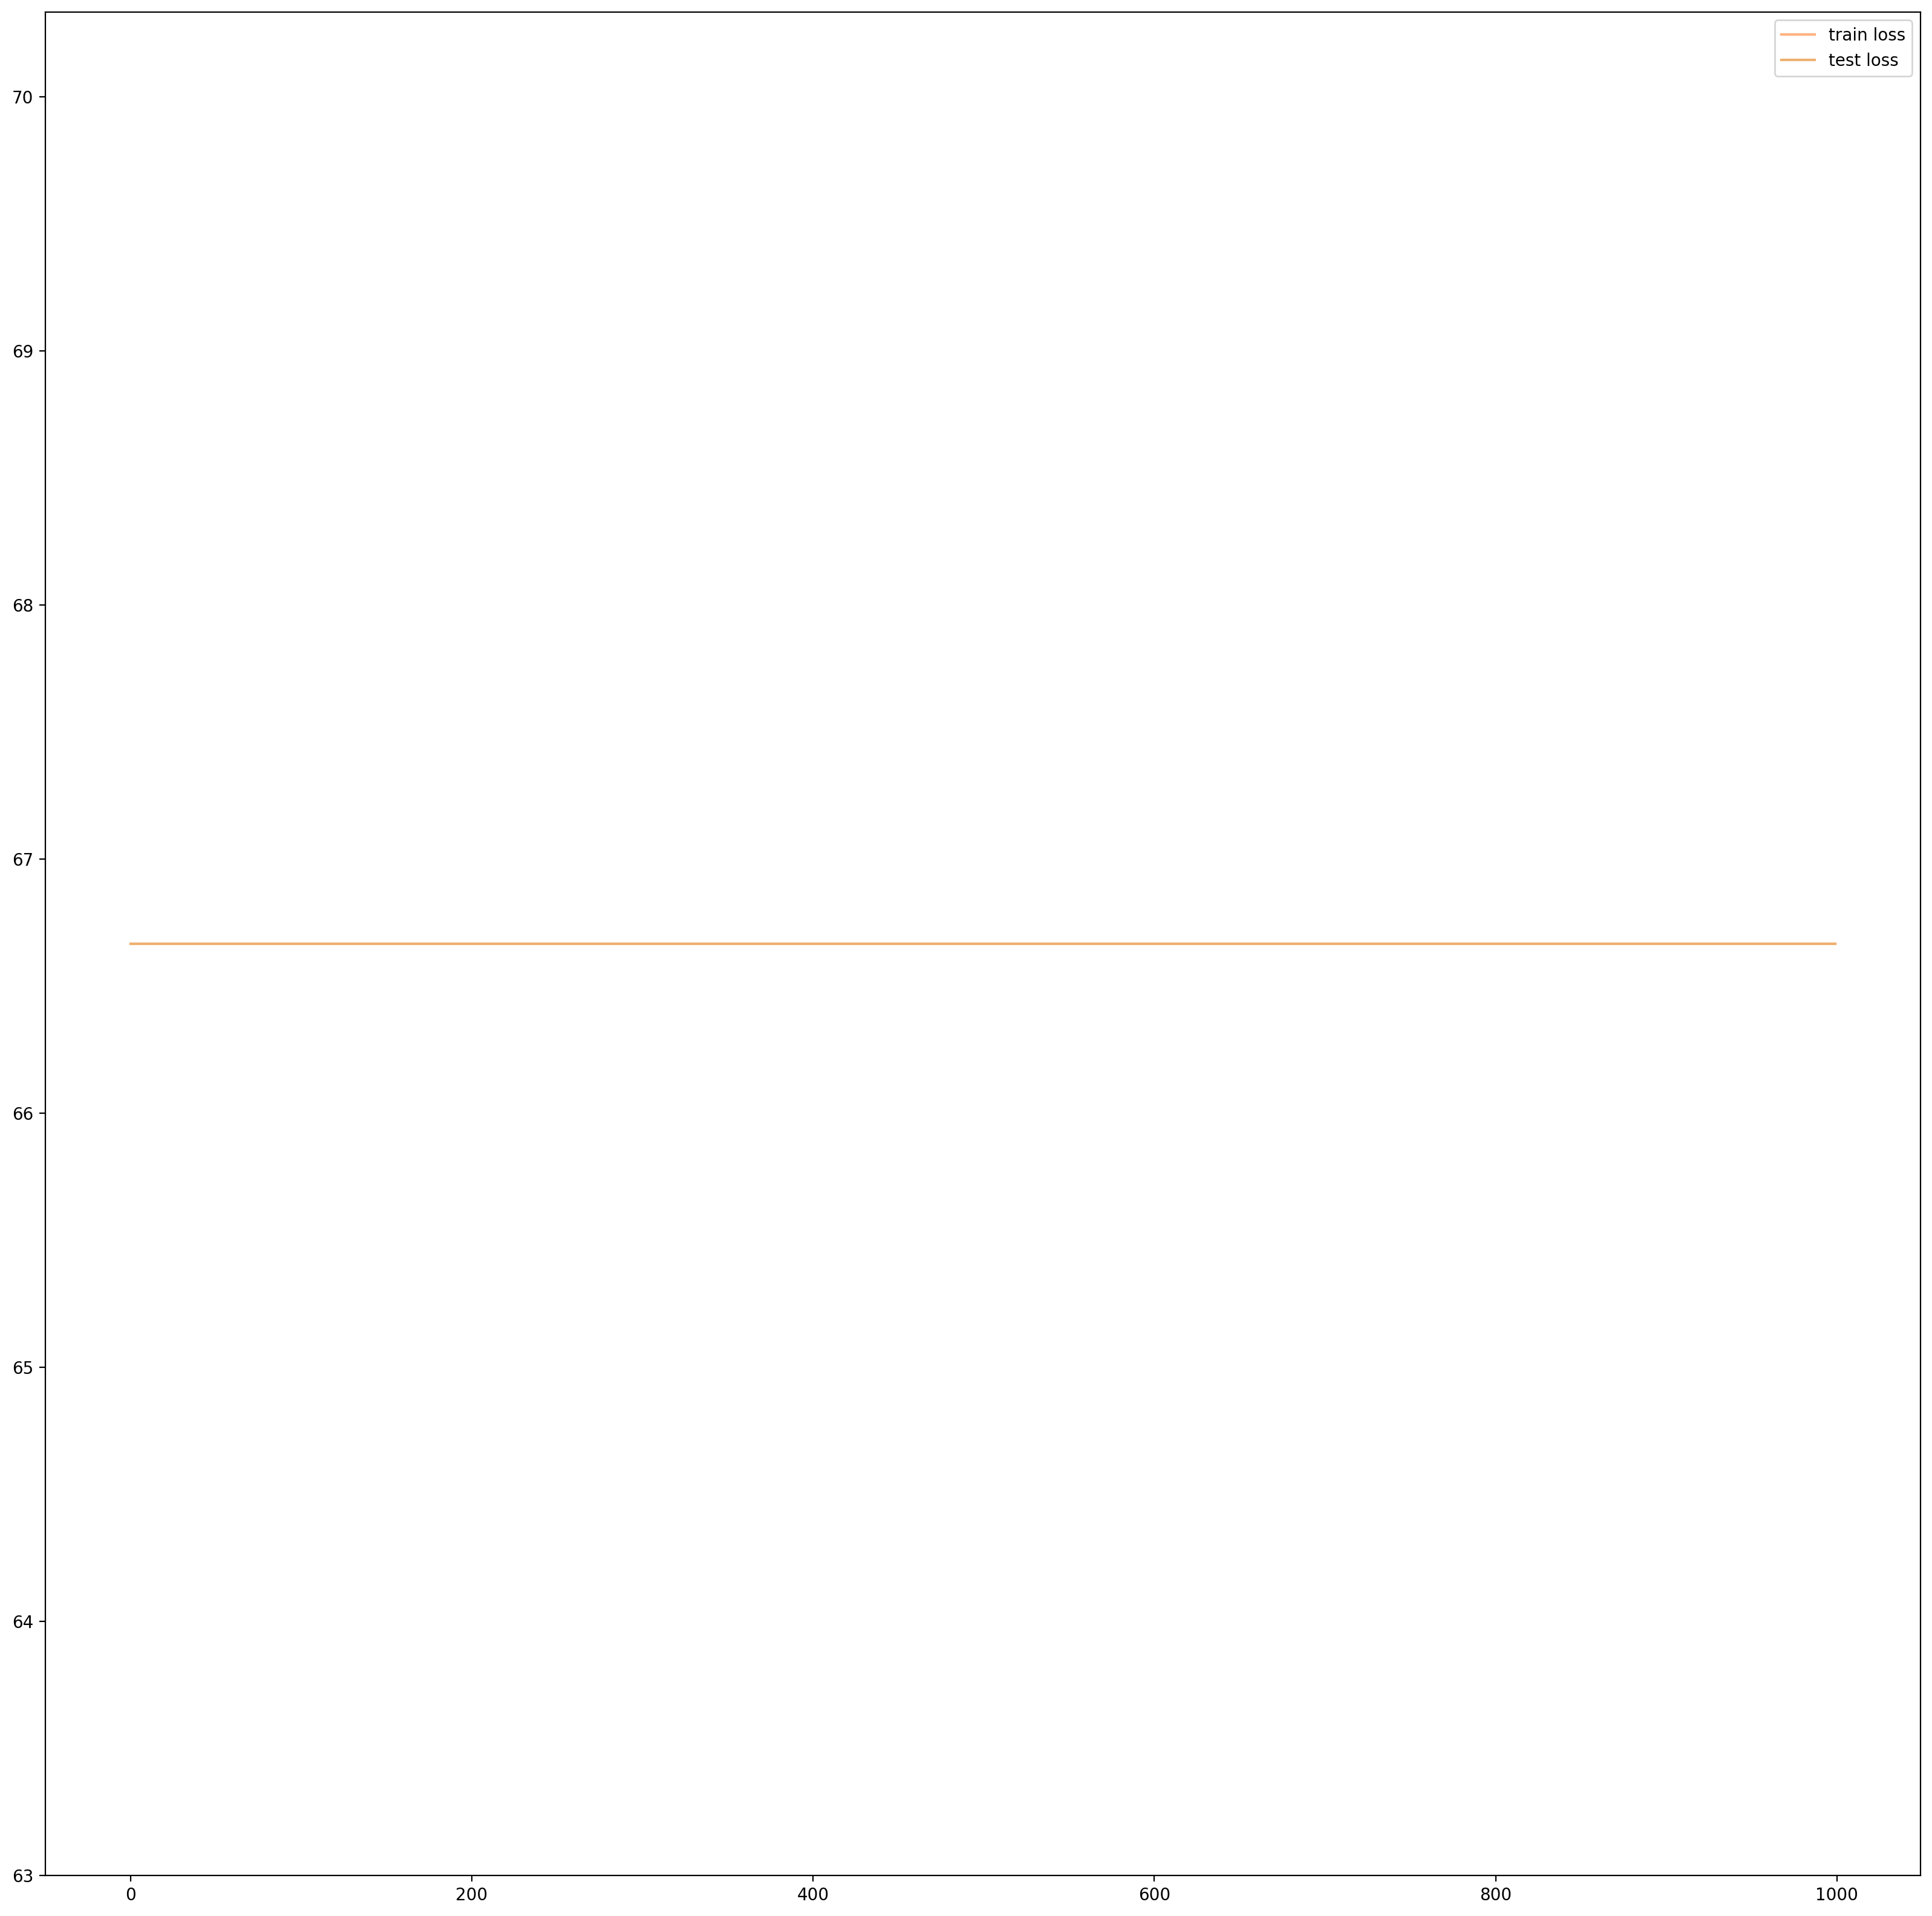

In [12]:
# in this code block we visualize the training loss and the test loss

plt.figure(figsize=(20,20),dpi=200)
plt.plot(ls_train, label='train loss', color='#ffb380')
plt.plot(ls_test, label='test loss', color='#eeb070')
plt.legend()
plt.show()
